# Prediction of Countries GDP Project

We will be using the 'Countries of The World' data set (from kaggle: Fernando Lasso: https://www.kaggle.com/fernandol/countries-of-the-world).

The dataset has 227 rows and 20 columns. Each column contains a different metric which helps us to measure the country's economic position.

The goal of our project is to analyze this dataset with the help of creative visualizations to gain some valuable insights, regarding the different factors which affect the GDP of a country. We will also create and train multiple Ml models which can be used to predict the GDP per capita of a country.

## Importing the required libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='darkgrid',context='notebook')
%matplotlib inline
%autosave 120

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb
from sklearn import metrics
from sklearn.linear_model import LinearRegression

import pickle

import warnings
warnings.filterwarnings("ignore")

Autosaving every 120 seconds


## Importing Data


In [4]:
df=pd.read_csv('Countries_GDP.csv')

## Data Description and Cleaning

In [5]:
df.head(5)

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",NaN,NaN,NaN


In [6]:
df.shape

(227, 20)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Country                             227 non-null    object 
 1   Region                              227 non-null    object 
 2   Population                          227 non-null    int64  
 3   Area (sq. mi.)                      227 non-null    int64  
 4   Pop. Density (per sq. mi.)          227 non-null    object 
 5   Coastline (coast/area ratio)        227 non-null    object 
 6   Net migration                       224 non-null    object 
 7   Infant mortality (per 1000 births)  224 non-null    object 
 8   GDP ($ per capita)                  226 non-null    float64
 9   Literacy (%)                        209 non-null    object 
 10  Phones (per 1000)                   223 non-null    object 
 11  Arable (%)                          225 non-n

* We observe that many of the numerical features, such as Birthrate, Deathrate, Agriculture, etc are of object type. We will need to convert all these object features to numerical/float in order to continue with the analysis.
* We will also change the column names to make thwm more compact and readable.

### Changing column names

In [8]:
df.columns=["country","region","population","area","density","coastline_area_ratio","net_migration","infant_mortality","gdp_per_capita",
                  "literacy","phones","arable","crops","other","climate","birthrate","deathrate","agriculture","industry",
                  "service"]

### Changing data type

In [9]:
df.country = df.country.astype('category')
df.region = df.region.astype('category')

list_of_cols=["density","coastline_area_ratio","net_migration","infant_mortality",
                  "literacy","phones","arable","crops","other","climate","birthrate","deathrate","agriculture","industry",
                  "service"]

def changing_dtype(df,col):
    df[col]=df[col].astype(str)
    df[col]=df[col].str.replace(',','.').astype(float)   # replacing ',' with '.'

In [10]:
for i in range(len(list_of_cols)):
    changing_dtype(df,list_of_cols[i])

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   country               227 non-null    category
 1   region                227 non-null    category
 2   population            227 non-null    int64   
 3   area                  227 non-null    int64   
 4   density               227 non-null    float64 
 5   coastline_area_ratio  227 non-null    float64 
 6   net_migration         224 non-null    float64 
 7   infant_mortality      224 non-null    float64 
 8   gdp_per_capita        226 non-null    float64 
 9   literacy              209 non-null    float64 
 10  phones                223 non-null    float64 
 11  arable                225 non-null    float64 
 12  crops                 225 non-null    float64 
 13  other                 225 non-null    float64 
 14  climate               205 non-null    float64 
 15  birthr

Now all columns are of the appropriate dtype.

In [12]:
df.describe()

,population,area,density,coastline_area_ratio,net_migration,infant_mortality,gdp_per_capita,literacy,phones,arable,crops,other,climate,birthrate,deathrate,agriculture,industry,service
count,2.270000e+02,2.270000e+02,227.000000,227.000000,224.000000,224.000000,226.000000,209.000000,223.000000,225.000000,225.000000,225.000000,205.000000,224.000000,223.000000,212.000000,211.000000,212.000000
mean,2.874028e+07,5.982270e+05,379.047137,21.165330,0.038125,35.506964,9689.823009,82.838278,236.061435,13.797111,4.564222,81.638311,2.139024,22.114732,9.241345,0.150844,0.282711,0.565283
std,1.178913e+08,1.790282e+06,1660.185825,72.286863,4.889269,35.389899,10049.138513,19.722173,227.991829,13.040402,8.361470,16.140835,0.699397,11.176716,4.990026,0.146798,0.138272,0.165841
min,7.026000e+03,2.000000e+00,0.000000,0.000000,-20.990000,2.290000,500.000000,17.600000,0.200000,0.000000,0.000000,33.330000,1.000000,7.290000,2.290000,0.000000,0.020000,0.062000
25%,4.376240e+05,4.647500e+03,29.150000,0.100000,-0.927500,8.150000,1900.000000,70.600000,37.800000,3.220000,0.190000,71.650000,2.000000,12.672500,5.910000,0.037750,0.193000,0.429250
50%,4.786994e+06,8.660000e+04,78.800000,0.730000,0.000000,21.000000,5550.000000,92.500000,176.200000,10.420000,1.030000,85.700000,2.000000,18.790000,7.840000,0.099000,0.272000,0.571000
75%,1.749777e+07,4.418110e+05,190.150000,10.345000,0.997500,55.705000,15700.000000,98.000000,389.650000,20.000000,4.440000,95.440000,3.000000,29.820000,10.605000,0.221000,0.341000,0.678500
max,1.313974e+09,1.707520e+07,16271.500000,870.660000,23.060000,191.190000,55100.000000,100.000000,1035.600000,62.110000,50.680000,100.000000,4.000000,50.730000,29.740000,0.769000,0.906000,0.954000


### Investigating undefined features

In [13]:
df.loc[: , ['country','climate','arable','crops','other','agriculture','industry','service']].head(3)

,country,climate,arable,crops,other,agriculture,industry,service
0,Afghanistan,1.0,12.13,0.22,87.65,0.380,0.240,0.380
1,Albania,3.0,21.09,4.42,74.49,0.232,0.188,0.579
2,Algeria,1.0,3.22,0.25,96.53,0.101,0.600,0.298


* The columns (arable, crops and other) are the precentage of total land mass that those activites account for. For example - In Afghaistan 12.13% of the land is arable whereas crops and other industries represent 0.22% and 87.65% of the land mass respectively.
* The columns (agriculture, industry and service) are the percentages that those sectors contribute to the total economic activity of the country. For example - In Albania agriculture generates 23.2% of the countries GDP, whereas industry and services account for 18.8% and 57.9% of the GDP respectively.

In [14]:
df.climate.unique()

array([1. , 3. , 2. , nan, 4. , 1.5, 2.5])

In [15]:
climate_data=df.loc[: , ['country','region','climate']]
vals=climate_data['climate'].isin([1,1.5,2,2.5,3,4])
climate_data[vals]

,country,region,climate
0,Afghanistan,ASIA (EX. NEAR EAST),1.0
1,Albania,EASTERN EUROPE,3.0
2,Algeria,NORTHERN AFRICA,1.0
3,American Samoa,OCEANIA,2.0
4,Andorra,WESTERN EUROPE,3.0
...,...,...,...
222,West Bank,NEAR EAST,3.0
223,Western Sahara,NORTHERN AFRICA,1.0
224,Yemen,NEAR EAST,1.0
225,Zambia,SUB-SAHARAN AFRICA,2.0


So, along with nan (representing missing data), climate has 6 unique values: 1, 1.5, 2, 2.5, 3, and 4. Observing the climate value and it's corresponding region and country, we can make the following inferences:

1. Countries with mostly desert/hot climate have 1
2. Countries with mostly tropical climate have 2
3. Countries with mostly cold/cool climate have 3
4. Countries with climate almost equally divided between hot and tropical have 1.5
5. Countries with climate almost equally divided between cold and tropical have 2.5
6. Countries under 'Climate' = 4, are also belonging to cold/cool climate group; It is not metioned in the dataset source why this group is separate from group 3.
7. There are 22 countries with null values for the climate column, these will be replaces by 0 in a later step, where 0 will represent 'unknown' value.

### Checking for Missing Values

In [16]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
    
missing_values_table(df)

Your selected dataframe has 20 columns.
There are 14 columns that have missing values.


,Missing Values,% of Total Values
climate,22,9.7
literacy,18,7.9
industry,16,7.0
agriculture,15,6.6
service,15,6.6
phones,4,1.8
deathrate,4,1.8
net_migration,3,1.3
infant_mortality,3,1.3
birthrate,3,1.3


We only have missing values in 14/20 columns. Missing values account for less than 10% of all the values in their respective columns.

1. net_migration: 3 missing data points, all of them belonging to very small nations. We will put zero for those 3.
2. infant_mortality: 3 missing data points, all of them belonging to very small nations. We will put zero for those 3.
3. gdp_per_capita: 1 missing value belonging to West Sahara, after searching from the net we find that their gdp_per_capita is $2500 as of 2007. We will replace the zero value with this.
4. literacy: 18 missing values, replacing by the mean literacy of each missing value's region.
5. phones: 4 missing values, replacing by the mean phones of each missing value's region.
6. arable, crops, and other: 2 missing values of very small islands, replacing with zero.
7. climate: 22 missing, replace with 0, where zero will represent an 'unknown' value.
8. birthrate, and deathrate: 3 missing, replacing with their region's mean rates, since those rates are per 1000, and not population related.
9. agricultue, industry, and service: 15 missing values, all belonging to very small island nations. After inspection for similar nations, we found that those kind of nations usually have economies that rely heavily on services, with some agricultural and industrial activities. So we will replace the missing values with the following: agricultue = 0.15, industry = 0.05. service = 0.8.

In [17]:
df['net_migration'].fillna(0, inplace=True)
df['infant_mortality'].fillna(0, inplace=True)
df['gdp_per_capita'].fillna(2500, inplace=True)

df['literacy'].fillna(df.groupby('region')['literacy'].transform('mean'), inplace= True)
df['phones'].fillna(df.groupby('region')['phones'].transform('mean'), inplace= True)
df['arable'].fillna(0, inplace=True)
df['crops'].fillna(0, inplace=True)
df['other'].fillna(0, inplace=True)

df['climate'].fillna(0, inplace=True)
df['birthrate'].fillna(df.groupby('region')['birthrate'].transform('mean'), inplace= True)
df['deathrate'].fillna(df.groupby('region')['deathrate'].transform('mean'), inplace= True)

df['agriculture'].fillna(0.15, inplace=True)
df['service'].fillna(0.8, inplace=True)
df['industry'].fillna(0.05, inplace= True)

In [18]:
df.isnull().sum()

country                 0
region                  0
population              0
area                    0
density                 0
coastline_area_ratio    0
net_migration           0
infant_mortality        0
gdp_per_capita          0
literacy                0
phones                  0
arable                  0
crops                   0
other                   0
climate                 0
birthrate               0
deathrate               0
agriculture             0
industry                0
service                 0
dtype: int64

## EDA

### Correlation Heatmap

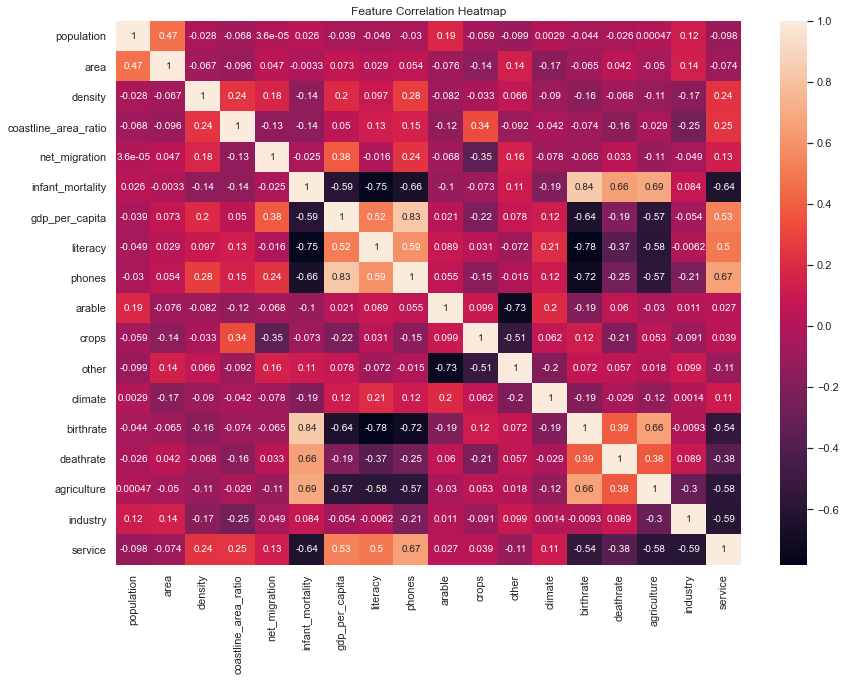

In [19]:
fig, ax = plt.subplots(figsize=(14,10)) 
sns.heatmap(df.corr(), annot=True).set(
    title = 'Feature Correlation Heatmap')
plt.show()

Some of the inferences we can make from the heatmap are:

1. Expected strong correlation between phones and GDP.
2. Expected strong correlation between birthrate and infant_mortality.
3. Expected strong negative correlation between infant_mortality and literacy.
4. Expected strong negative correlation between literacy and birthrate.
5. Expected strong correlation between phones and service.
6. Unexpected strong negative correlation between birthrate and phones.
7. Unexpected weak negative correlation between GDP and industry.
8. Expected moderate correlation between GDP and net_migration. Migrants tend to move to countries with better financial oppurtunities.

### Regional analysis 

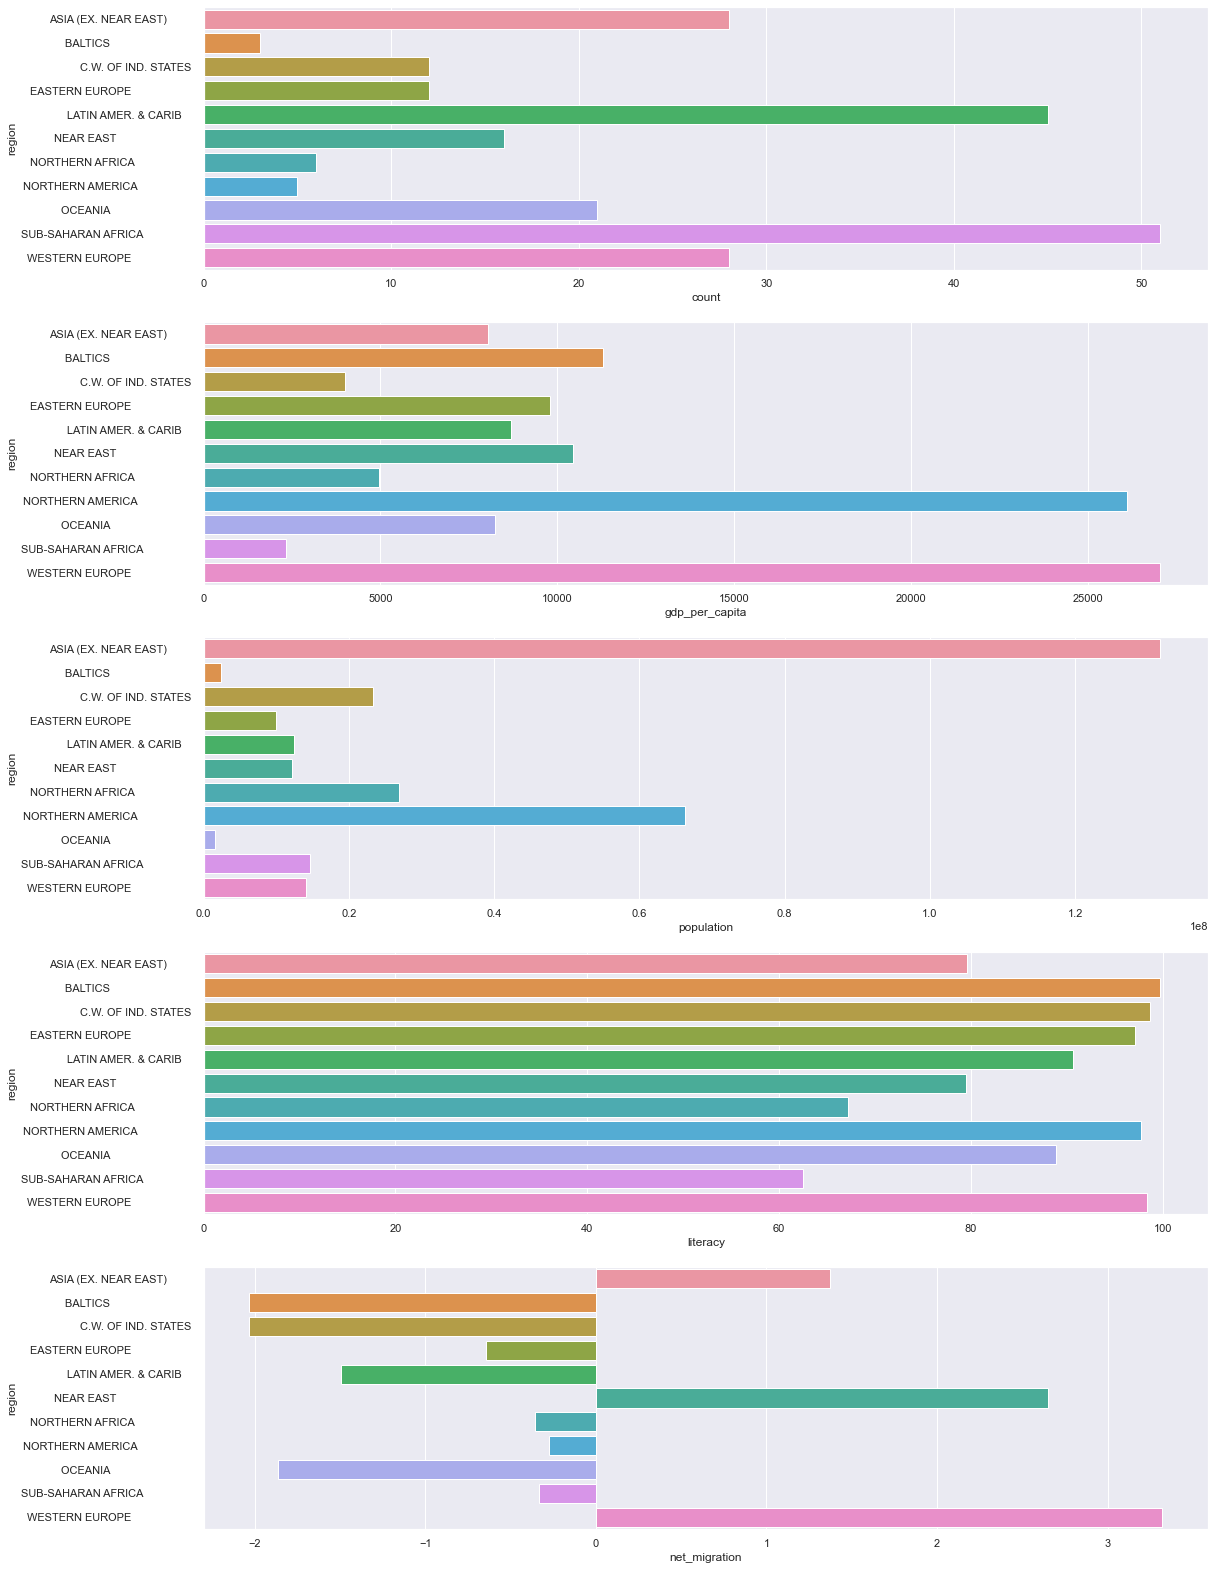

In [20]:
fig=plt.figure(figsize=(18,28))
ax1=fig.add_subplot(5,1,1)
ax2=fig.add_subplot(5,1,2)
ax3=fig.add_subplot(5,1,3)
ax4=fig.add_subplot(5,1,4)
ax5=fig.add_subplot(5,1,5)

sns.countplot(y='region', data=df,ax=ax1)
sns.barplot(x='gdp_per_capita', y='region' , data=df , ax=ax2 , ci=None)
sns.barplot(x='population' , y='region' , data=df , ax=ax3 , ci=None)
sns.barplot(x='literacy' , y='region' , data=df , ax=ax4 , ci=None)
sns.barplot(x='net_migration' , y='region' , data=df , ax=ax5 , ci=None)

plt.show()

We can make the following observations from the plot:

1. Sub-Saharian Africa and Latin America regions have the most countries whithin them.
2. Western Europe and North America have the highest GDP per capita, while Sub-Saharian Africa has the lowest GDP per capita.
3. Literacy rates are lower in Northern and Sub-Saharan Africa as compared to the rest of the world.
4. Asia has the largest population, whereas Oceania has the smallest.

### GDP Analysis

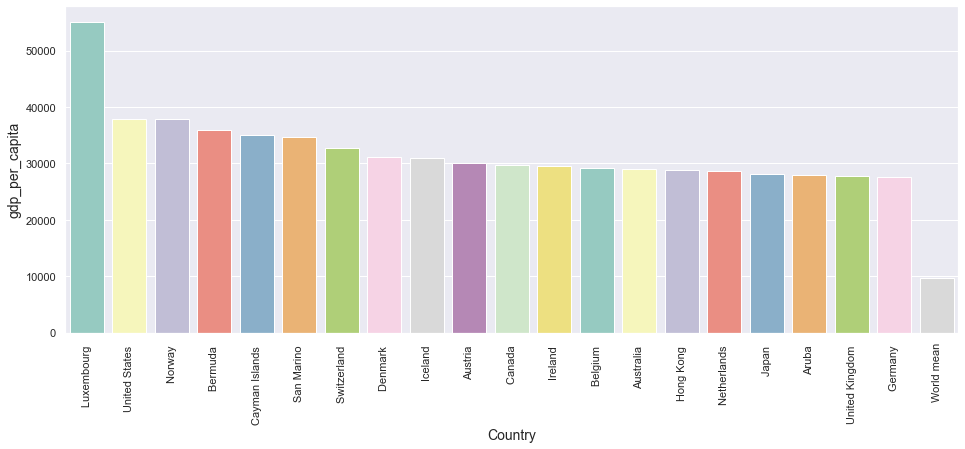

In [21]:
fig= plt.figure(figsize=(16,6))

top_gdp_countries = df.sort_values('gdp_per_capita',ascending=False).head(20)
mean = pd.DataFrame({'country':['World mean'], 'gdp_per_capita':[df['gdp_per_capita'].mean()]})
df1 = pd.concat([top_gdp_countries[['country','gdp_per_capita']],mean],ignore_index=True)

sns.barplot(x='country',y='gdp_per_capita',data=df1, palette='Set3')
plt.xlabel('Country', fontdict={'fontsize':14})
plt.ylabel('gdp_per_capita' ,fontdict={'fontsize':14})
plt.xticks(rotation=90)
plt.show()

* As expected we can see that the gdp_per_capita is highest in Western European and Northern American countries.

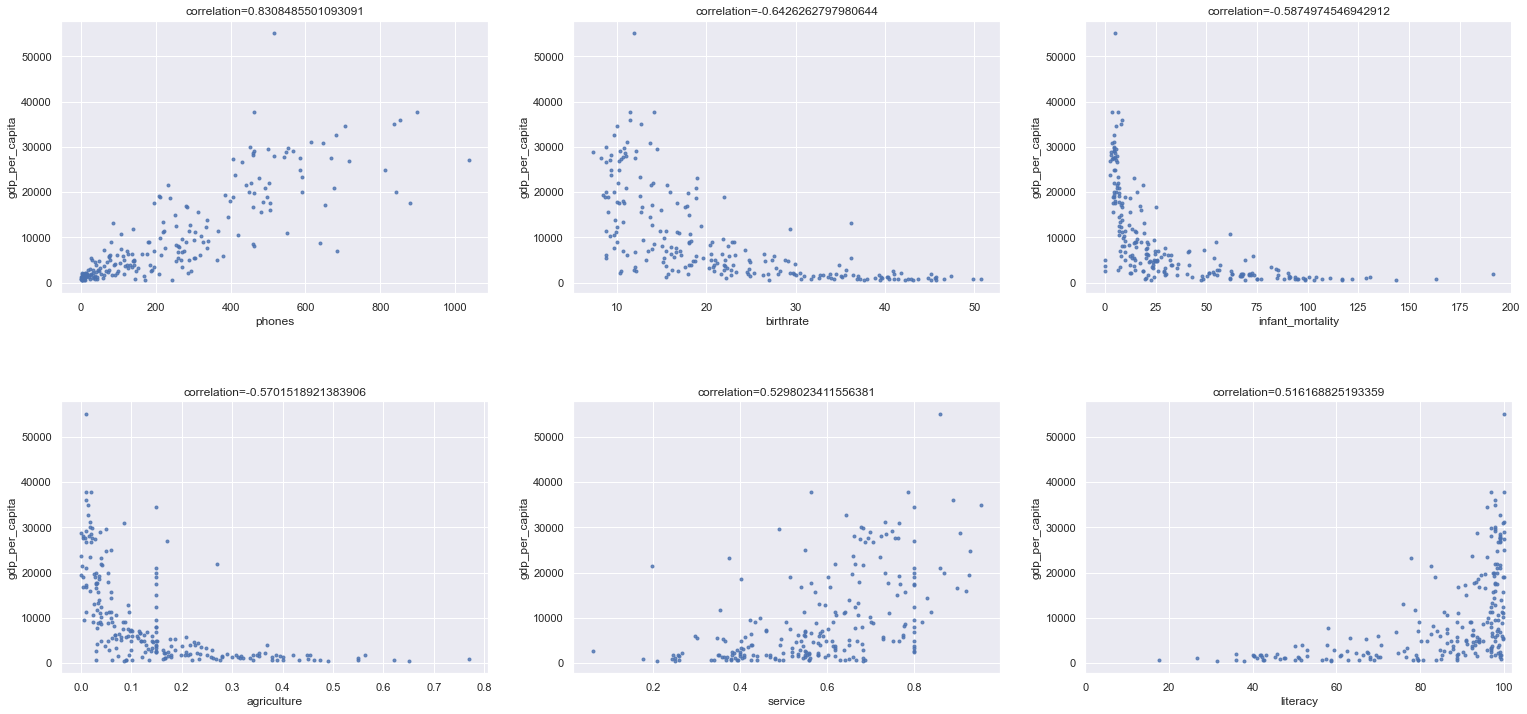

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(26,12))
plt.subplots_adjust(hspace=0.4)

corr_to_gdp = pd.Series()
for col in df.columns.values[2:]:
    if ((col!='gdp_per_capita')&(col!='climate')):
        corr_to_gdp[col] = df['gdp_per_capita'].corr(df[col])
abs_corr_to_gdp = corr_to_gdp.abs().sort_values(ascending=False)
corr_to_gdp = corr_to_gdp.loc[abs_corr_to_gdp.index]

for i in range(2):
    for j in range(3):
        sns.regplot(x=corr_to_gdp.index.values[i*3+j], y='gdp_per_capita', data=df,
                   ax=axes[i,j], fit_reg=False, marker='.')
        title = 'correlation='+str(corr_to_gdp[i*3+j])
        axes[i,j].set_title(title)
axes[1,2].set_xlim(0,102)
plt.show()

* From the above plots we can clearly see that the countries with high GDP's also have very high literacy rates. 
* The infant mortality rate is higher in poorer countries as compared to that in richer countries.
* There is a positive relationship between the number of phones(per 1000 people) and GDP. As the number of phones being used by the people increases, the GDP increases as well.
* As the percentage of contribution of the Service industry to the economy increases the GDP increases as well.
* The GDP decreases if the share of Agriculture in the economy increases.
* No significant relationship between GDP and share of Industry in the economy. 

## Data Pre-conditioning

In this section we will make our data ready for model training. This will include:

1. Transforming 'region' and 'climate; column into numerical values.
2. Splitting the data into training and testing parts, while dropping the countries column, and separating gdp_per_capita column as it is the target variable.

In [23]:
LE = LabelEncoder()
df['region_label'] = LE.fit_transform(df['region'])
df['climate_label'] = LE.fit_transform(df['climate'])
print(df.shape)
df.head()

(227, 22)


,country,region,population,area,density,coastline_area_ratio,net_migration,infant_mortality,gdp_per_capita,literacy,...,crops,other,climate,birthrate,deathrate,agriculture,industry,service,region_label,climate_label
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,48.0,0.00,23.06,163.07,700.0,36.0,...,0.22,87.65,1.0,46.60,20.34,0.380,0.240,0.380,0,1
1,Albania,EASTERN EUROPE,3581655,28748,124.6,1.26,-4.93,21.52,4500.0,86.5,...,4.42,74.49,3.0,15.11,5.22,0.232,0.188,0.579,3,5
2,Algeria,NORTHERN AFRICA,32930091,2381740,13.8,0.04,-0.39,31.00,6000.0,70.0,...,0.25,96.53,1.0,17.14,4.61,0.101,0.600,0.298,6,1
3,American Samoa,OCEANIA,57794,199,290.4,58.29,-20.71,9.27,8000.0,97.0,...,15.00,75.00,2.0,22.46,3.27,0.150,0.050,0.800,8,3
4,Andorra,WESTERN EUROPE,71201,468,152.1,0.00,6.60,4.05,19000.0,100.0,...,0.00,97.78,3.0,8.71,6.25,0.150,0.050,0.800,10,5


In [24]:
training_features=['population', 'area', 'density', 'coastline_area_ratio',
       'net_migration', 'infant_mortality', 'literacy',
       'phones', 'arable', 'crops', 'other', 'birthrate',
       'deathrate', 'agriculture', 'industry', 'service',
      'climate_label','region_label']

target=['gdp_per_capita']

x=df[training_features]
y=df[target]

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [25]:
def metric():
    rmse_train = np.sqrt(metrics.mean_squared_error(y_train_pred, y_train))
    mae_train=metrics.mean_absolute_error(y_train_pred,y_train)
    r2_score_train=metrics.r2_score(y_train_pred,y_train)

    rmse_test = np.sqrt(metrics.mean_squared_error(y_test_pred, y_test))
    mae_test=metrics.mean_absolute_error(y_test_pred, y_test)
    r2_score_test=metrics.r2_score(y_test_pred, y_test)
    
    print('RMSE_train:',rmse_train, 'MAE_train:',mae_train, 'R2_train:', r2_score_train)
    print('\nRMSE_test:',rmse_test, 'MAE_test:',mae_test, 'R2_test:', r2_score_test)
    
    return

## Building the model

We will be building the following models:
* Linear Regression ( baseline model)
* Random Forest Regressor
* Gradient Boosting Regressor

### Linear Regression

In [26]:
model=LinearRegression()

model.fit(x_train,y_train)
y_train_pred=model.predict(x_train)
y_test_pred=model.predict(x_test)

metric()
scores = cross_val_score(model, x_train,y_train,cv=5)
print("\nMean cross-validation score: %.2f" % scores.mean())

RMSE_train: 4877.790351389555 MAE_train: 3442.351823394902 R2_train: 0.7051188292719435

RMSE_test: 4025.5959600560586 MAE_test: 3151.3250957012124 R2_test: 0.7819061271754701

Mean cross-validation score: 0.55


* We can see that the target is not linear with all the features, hence we should try fitting some non linear models to the data as well.

### Random Forest

In [27]:
model = RandomForestRegressor(n_estimators = 200,
                             max_depth = 6,
                             max_features = 2, min_samples_leaf=1,criterion='mse',
                             random_state = 42)

model.fit(x_train,y_train)
y_train_pred=model.predict(x_train)
y_test_pred=model.predict(x_test)

metric()
scores = cross_val_score(model, x_train,y_train,cv=5)
print("\nMean cross-validation score: %.2f" % scores.mean())

RMSE_train: 2228.3711093125817 MAE_train: 1609.7547737998927 R2_train: 0.9364494350699396

RMSE_test: 2484.9805143687763 MAE_test: 1917.881541053297 R2_test: 0.9037539313283529

Mean cross-validation score: 0.73


* The RandomForestRegressor performed better than the Linear Regression model. We have achieved a greater R2 score and decreased RMSE and MAE values for both train and test sets.
* Now we will try to improve the performance of the RandomForest even more by applying GridSearchCV to optimize it's hyperparameters.

#### Optimization

* Our optimization here will be limited due to time and computing power constraints.

In [28]:
param_grid={'n_estimators':[50,100,150], 'bootstrap': [True,False]
           , 'min_samples_leaf': [1,2], 'max_features':[2,3,4], 
            'max_depth':[5,7,8]}

rf_grid=GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, verbose=0 ,cv=5)

rf_grid.fit(x_train,y_train)
print(rf_grid.best_params_)

{'bootstrap': False, 'max_depth': 7, 'max_features': 3, 'min_samples_leaf': 1, 'n_estimators': 100}


* Using these hyperparameters to build a new RandomForest model.

In [29]:
rf=RandomForestRegressor(bootstrap=False,max_depth=7,max_features=3,min_samples_leaf=1,n_estimators=100, criterion='mse')
rf.fit(x_train,y_train)

y_train_pred=model.predict(x_train)
y_test_pred=model.predict(x_test)

metric()
scores = cross_val_score(rf, x_train,y_train,cv=5)
print("\nMean cross-validation score: %.2f" % scores.mean())

RMSE_train: 2228.3711093125817 MAE_train: 1609.7547737998927 R2_train: 0.9364494350699396

RMSE_test: 2484.9805143687763 MAE_test: 1917.881541053297 R2_test: 0.9037539313283529

Mean cross-validation score: 0.76


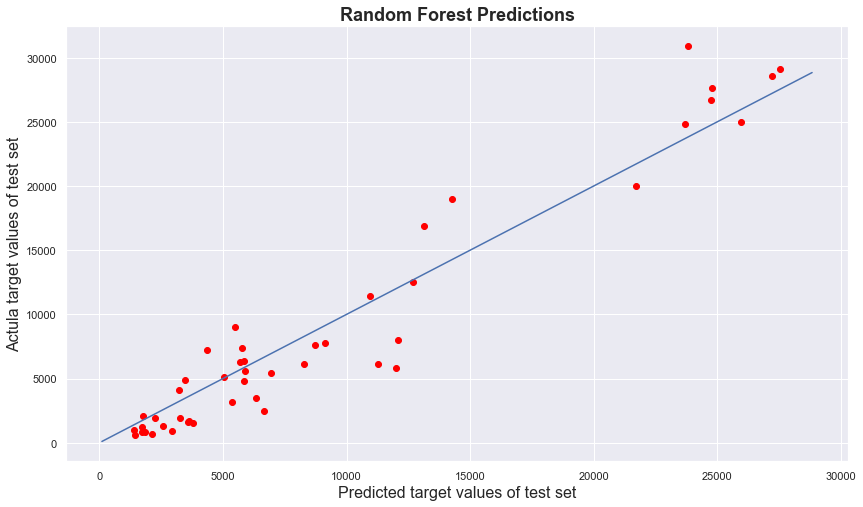

In [30]:
fig, ax=plt.subplots(figsize=(14,8))
plt.scatter(x=y_test_pred,y=y_test,c='red')
plt.xlabel('Predicted target values of test set', fontdict={'fontsize':16})
plt.ylabel('Actula target values of test set', fontdict={'fontsize':16})
plt.title('Random Forest Predictions', fontdict={'fontsize':18, 'fontweight':'bold'})
x = np.linspace(*ax.get_xlim())
ax.plot(x, x)
plt.show()

* The diagnol blue line represents the line made by the points if the model predicted the test values perfectly.
* It appears that we have maxed out the performance of the model as there is no significant change in the evaluation metrics after applying GridSearchCV.

### Gradient Boosting

In [31]:
gbm = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_depth=3,
                                 subsample=1.0, max_features= None, random_state=39)

gbm.fit(x_train,y_train)

y_train_pred=gbm.predict(x_train)
y_test_pred=gbm.predict(x_test)

metric()
scores = cross_val_score(gbm, x_train,y_train,cv=5)
print("\nMean cross-validation score: %.2f" % scores.mean())

RMSE_train: 652.2228208630505 MAE_train: 508.16027587001935 R2_train: 0.99579435181908

RMSE_test: 2993.5334221561147 MAE_test: 2130.3473290938414 R2_test: 0.8880952886037878

Mean cross-validation score: 0.73


* We are getting a very high R2_train score and very low RMSE_train scores, but the testing metric values are comparable to those of Random Forest. Thus we can see that the performance of both these models is similar, with Random Forest performing sligthly better.

####  Feature Importance

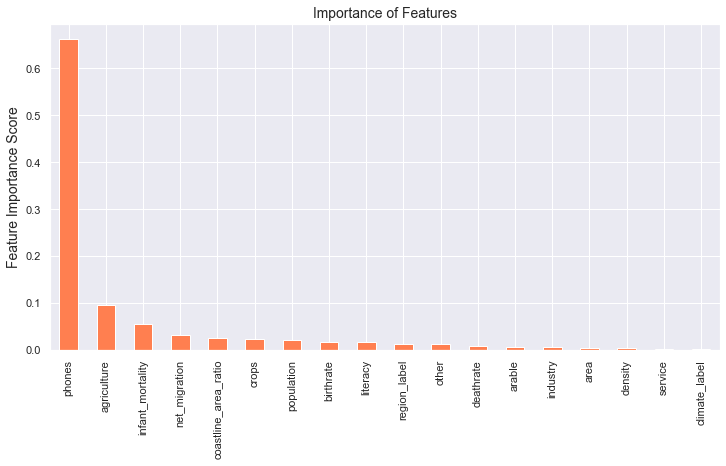

In [32]:
fig = plt.figure(figsize=(12, 6))
feat_imp = pd.Series(gbm.feature_importances_, list(x_train)).sort_values(ascending=False)
feat_imp.plot(kind='bar',color= 'coral')
plt.ylabel('Feature Importance Score', fontdict={'fontsize': 14})
plt.title(label='Importance of Features', fontdict={'fontsize': 14} )
plt.show()

* The metric phones(per 1000) seems to have the most importance in the model before it is optimized. All the other metrics seem to have very little importance when compared to the metric 'phones'.
* Next we will try to optimize GBM, and compare its performance to that of Random Forest. Also, we will plot the feature importance chart, and observe if GBM changed the features importance score after optimization.

#### Optimization

* We will now apply GridSearchCV to our Gradient Boosting model
* Our optimization here will be limited due to time and computing power constraints.

In [33]:
gbm_param_grid = {'learning_rate':[0.1,0.15], 
           'n_estimators':[50,100,150],
          'max_depth':[1,2,3],
          'subsample':[0.7,0.9], 
          'min_samples_leaf':[0.5,1,2],
          'min_samples_split':[10, 20],
          'max_features':[2,4,5]}

gbm_tuning = GridSearchCV(estimator =gbm, param_grid = gbm_param_grid, n_jobs=-1, cv=5, verbose=0)

gbm_tuning.fit(x_train,y_train)
print(gbm_tuning.best_params_)

{'learning_rate': 0.15, 'max_depth': 2, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100, 'subsample': 0.9}


In [34]:
gbm1 = GradientBoostingRegressor(learning_rate=0.15, n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_depth=2,
                                 subsample=0.9, max_features= 4, random_state=39)

gbm1.fit(x_train,y_train)

y_train_pred=gbm1.predict(x_train)
y_test_pred=gbm1.predict(x_test)

metric()
scores = cross_val_score(gbm1, x_train,y_train,cv=5)
print("\nMean cross-validation score: %.2f" % scores.mean())

RMSE_train: 1493.1202717125811 MAE_train: 1106.7321020335792 R2_train: 0.976882291625335

RMSE_test: 2447.968934551082 MAE_test: 1865.1781159964487 R2_test: 0.9277099481978738

Mean cross-validation score: 0.80


* After optimizing the hyperparameters we find that the performance of the model has improved significantly. It has surpassed the Random Forest model in terms of R2_test score, cross_validation score and also has lower RMSE and MAE values.

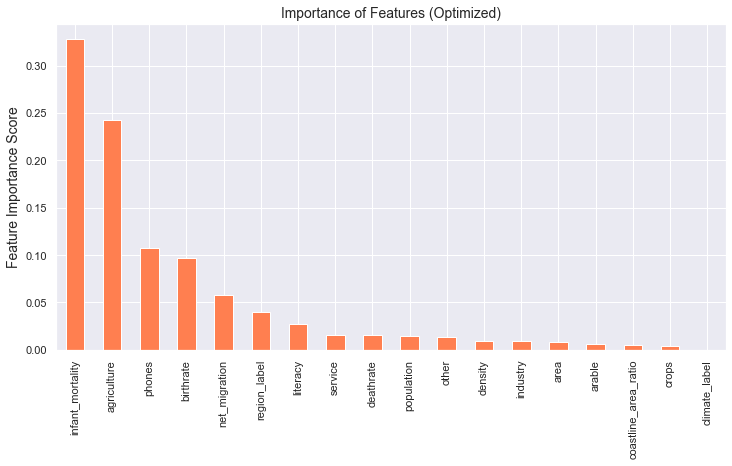

In [35]:
feat_imp2 = pd.Series(gbm1.feature_importances_, list(x_train)).sort_values(ascending=False)
fig = plt.figure(figsize=(12, 6))
feat_imp2.plot(kind='bar', color= 'coral')
plt.ylabel('Feature Importance Score', fontdict={'fontsize': 14})
plt.title(label='Importance of Features (Optimized)', fontdict={'fontsize': 14})
plt.show()

* The feature importances are much more distributed now than they were before optimization.
* The importance of the feature 'phones' has dropped dramatically and it is now similar to those of other features.
* As we can see this has improved the performance of our model, as now it is not dependent primarily on a single feature but instead, uses multiple features together to predict the target variable.

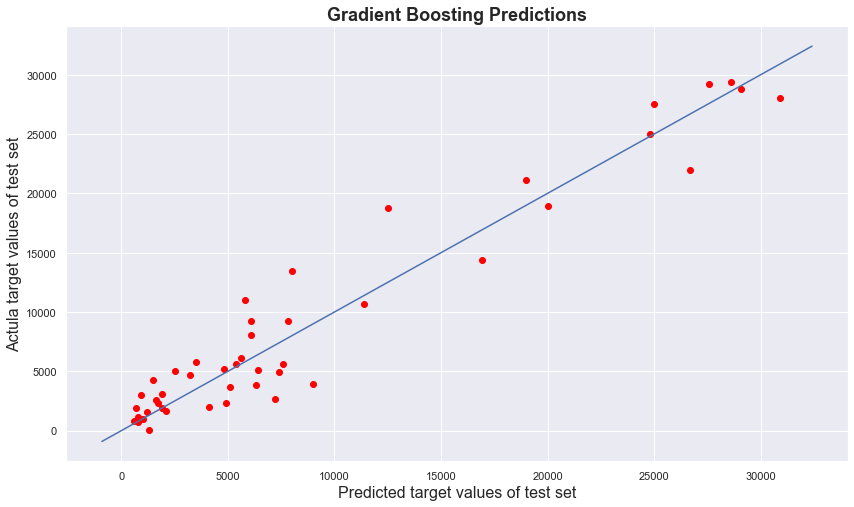

In [36]:
fig,ax=plt.subplots(figsize=(14,8))
plt.scatter(y_test,y_test_pred,c='red')
plt.xlabel('Predicted target values of test set', fontdict={'fontsize':16})
plt.ylabel('Actula target values of test set', fontdict={'fontsize':16})
plt.title('Gradient Boosting Predictions', fontdict={'fontsize':18, 'fontweight':'bold'})
x = np.linspace(*ax.get_xlim())
ax.plot(x, x)
plt.show()

## Conclusion and saving the model

In this project, we used "countries_of_the_world" dataset to build a GDP predictor. 3 different learning regressors (Linear Regression, Random Forest, and Gradient Boosting) were tested. We acheived the best prediction performance using Gradient Boosting Regressor , followed by Random Forest Regressor, while Linear Regression achieved the worst performance of the 3. 

The best prediction performance was acheived using ***Gradient Boosting Regressor*** , using all features in the dataset, and resulted in the following metrics:

* Root Mean Squared Error(RMSE): ***2447.96***
* Mean Absolute Error(MAE): ***1865.17*** 
* R-Squared Score(R2 Score): ***0.927*** 
* Cross Validation Score: ***0.80***

In [37]:
pickle.dump(gbm1, open('model.pk','wb'))